# Transfer learning resnet18 on mnist numbers

In [1]:
from fastcore.all import *
from fastai.vision.all import *
import pathlib

In [2]:
! wandb login

wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


In [3]:
import wandb
from fastai.callback.wandb import *

wandb.init(project="phcd_numbers", name='fastai_resnet18_mnist')

wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


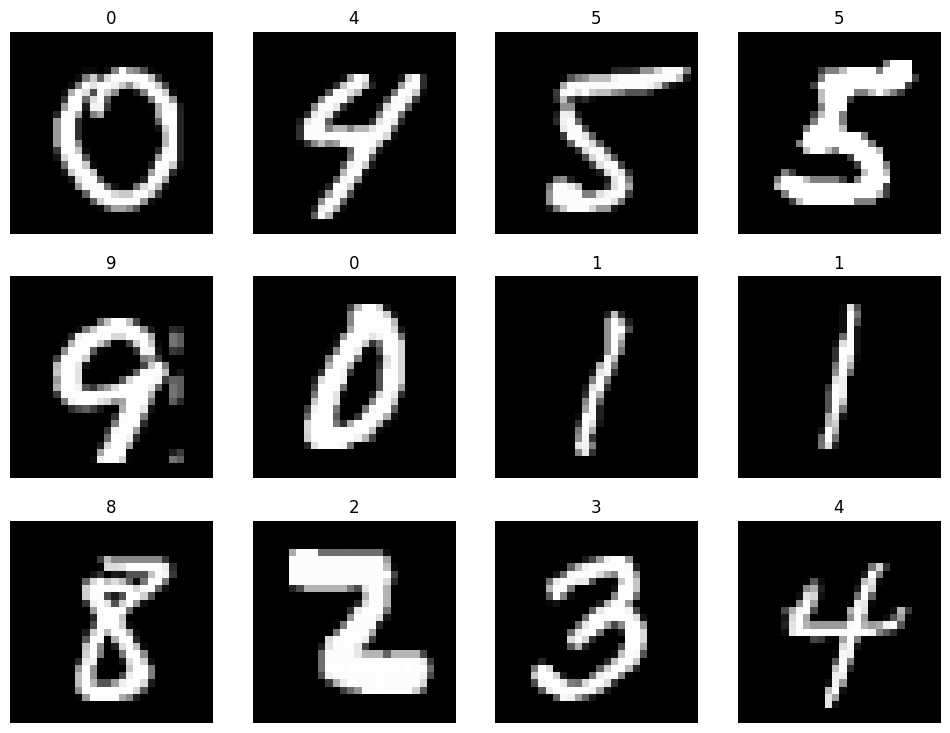

In [4]:
from fastai.vision import *

path = untar_data(URLs.MNIST)

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
).dataloaders(path, bs=128, num_workers=0)

dls.show_batch(max_n=12)

# log dataset metadata

In [14]:
# get number of classes in dls
num_classes = len(dls.vocab)

# get total number of training examples
num_train = len(dls.train_ds)

print(f"Number of classes: {num_classes}")
print(f"Number of training examples: {num_train}")

wandb.log({
    "number_of_classes": num_classes,
    "number_of_training_examples": num_train})

Number of classes: 10
Number of training examples: 56000


In [5]:
learn = vision_learner(dls, resnet18, metrics=error_rate, cbs=WandbCallback())
learn.fine_tune(3)

/home/wiktor/.pyenv/versions/3.9.10/envs/master-thesis/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/wiktor/.pyenv/versions/3.9.10/envs/master-thesis/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.797696,0.534497,0.171071,00:54


epoch,train_loss,valid_loss,error_rate,time
0,0.133160,0.087500,0.027286,01:01
1,0.065698,0.052845,0.015786,01:01
2,0.026261,0.048784,0.013714,01:01


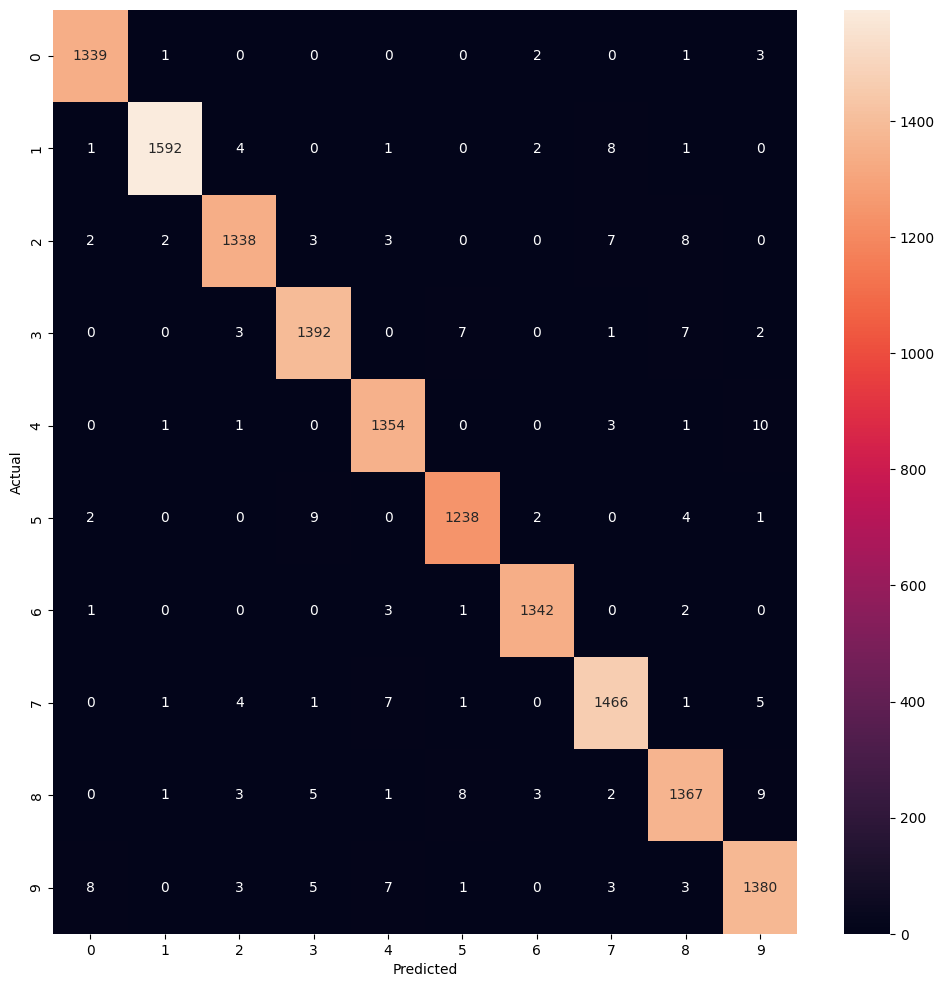

In [6]:
import seaborn as sns

interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.confusion_matrix()
# plot seaborn confusion matrix with figsize (12,12) and cmap plasma
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="rocket", ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

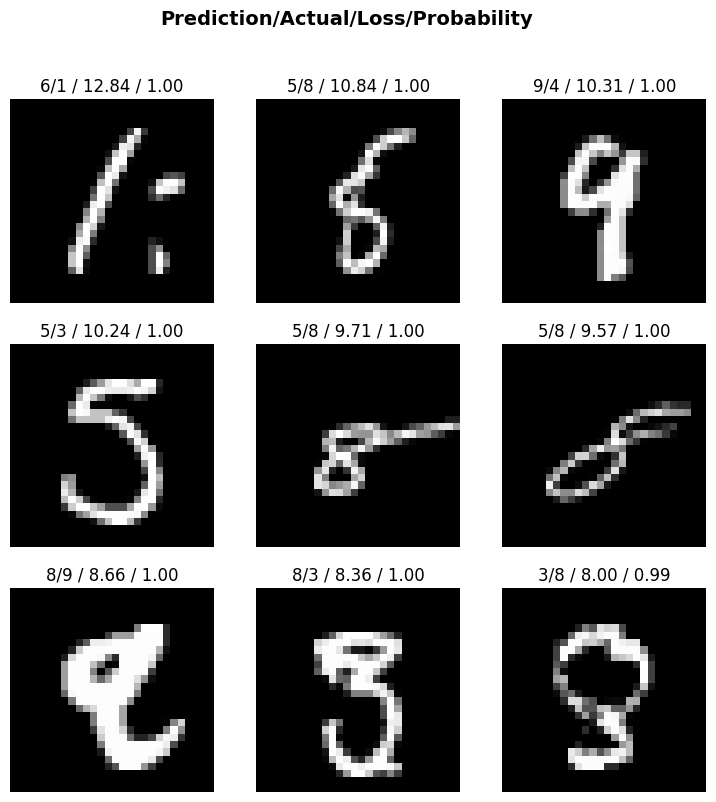

In [7]:
interp.plot_top_losses(9, nrows=3)

In [8]:
learn.export('../models/fastai_resnet18_mnist.pkl')

In [10]:
test_data_path = pathlib.Path("../data/numbers/test")
test_dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    #splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
).dataloaders(test_data_path, bs=32)

In [11]:
learn2 = load_learner('../models/fastai_resnet18_mnist.pkl') 
learn2.dls = test_dls

In [12]:
preds, y, decoded = learn.get_preds(with_decoded=True)
# get accuracy
acc = accuracy(preds, y)
print(f"Accuracy: {float(acc)*100:.5f}%")

Accuracy: 98.62857%


In [13]:
# wandb log confusion matrix

wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=y.numpy(), preds=decoded.numpy(), class_names=interp.vocab)})

#